In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.evaluate_basset_performance import *

In [8]:
data_dir = "/clusterfs/nilah/pooja/kidney_data"
fig_dir = "/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/figures"

targets = pd.read_csv(f"{data_dir}/targets.txt", sep="\t", header=0, index_col=0)
cell_types = targets["identifier"].values

cell_type_peak_set_mapping = {"PT": ["cluster11_PT", "cluster3_Ubiquitous", "all_sequences"],
                              "DT": ["cluster4_DistalNephron", "cluster3_Ubiquitous", "all_sequences"],
                              "LOH": ["cluster4_DistalNephron", "cluster3_Ubiquitous", "all_sequences"],
                              "Str": ["cluster9_Stroma", "cluster3_Ubiquitous", "all_sequences"],}


tasks = ["single_task", "multitask"]
training_sets = ["all_sequences", "1_1_peaks_non_peaks", "1_1_gc_matched",
                 "remove_non_peaks", "remove_non_peaks_ubiq_peaks"]

### Read in data

In [24]:
# reference accuracy
ref_acc_by_cluster_replicates = read_reference_accuracy_replicates(data_dir, cell_type_peak_set_mapping.keys(), 
                                                                   tasks, training_sets)
formatted_df = format_df_to_plot(ref_acc_by_cluster_replicates, cell_type_peak_set_mapping,
                                 tasks, training_sets)
formatted_df.loc[~formatted_df["Cluster"].isin(['cluster3_Ubiquitous', 'all_sequences']), 
                 "Cluster"] = "Cell-type specific"



In [41]:
# allelic imbalance accuracy
cell_type_peak_set_mapping = {"PT": ["cluster11_PT_matched", "cluster3_Ubiquitous_matched"],
                              "DT": ["cluster4_DistalNephron_matched", "cluster3_Ubiquitous_matched"],
                              "LOH": ["cluster4_DistalNephron_matched", "cluster3_Ubiquitous_matched"],
                              "Str": ["cluster9_Stroma_matched", "cluster3_Ubiquitous_matched"]}

allelic_imbalance_by_cluster_replicates = read_imbalance_accuracy_replicates(data_dir,
                                                                             cell_type_peak_set_mapping.keys(),
                                                                             tasks, training_sets)
allelic_imbalance_formatted_df = format_df_to_plot(allelic_imbalance_by_cluster_replicates, 
                                                   cell_type_peak_set_mapping,
                                                   tasks, training_sets)
allelic_imbalance_formatted_df.loc[~allelic_imbalance_formatted_df["Cluster"].isin(['cluster3_Ubiquitous_matched']), 
                                   "Cluster"] = "Cell-type specific"

In [14]:
# cross cell type correlations
targets_dir = f"{data_dir}/CellTypeSpecificPeakClusters_ArchR_clust11/model_predictions"
models_dir = f"{data_dir}/train/replicate_models"
multitask_model = f"{models_dir}/train__multitask__all_sequences__1"
single_task_model = models_dir + "/train__single_task__{cell_type}__all_sequences__1"


cell_type_peak_set_mapping = {"PT": ["cluster11_PT", "cluster3_Ubiquitous"],
                             "DT": ["cluster4_DistalNephron", "cluster3_Ubiquitous"],
                             "LOH": ["cluster4_DistalNephron", "cluster3_Ubiquitous"],
                             "Str": ["cluster9_Stroma", "cluster3_Ubiquitous"]}


model_preds = {"Multi-task predictions": read_multi_task_targets_predictions(multitask_model, 
                                                                 targets_dir,
                            np.unique(np.concatenate(list(cell_type_peak_set_mapping.values()))), 
                                                                 cell_types),
               "Single-task predictions": read_single_task_targets_predictions(single_task_model,
                                                                   targets_dir,
                            np.unique(np.concatenate(list(cell_type_peak_set_mapping.values()))), 
                                                                    cell_type_peak_set_mapping.keys())}

cross_cell_type_correlations = compute_cross_cell_type_correlations(model_preds, 
                                                                    cell_type_peak_set_mapping, 
                                                                    "cluster3_Ubiquitous")

### Fig 3C -- Cell-type specific vs ubiquitous

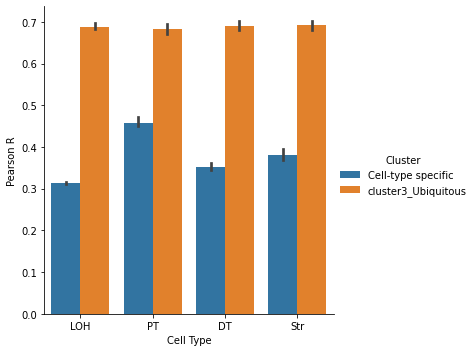

In [18]:
sns.catplot(data=formatted_df[(formatted_df["Training Data"] == "all_sequences") &
                              (formatted_df["Training Task"] == "multitask") &
                              (formatted_df["Cluster"].isin(["cluster3_Ubiquitous", "Cell-type specific"]))],
            x="Cell Type", y="Pearson R", hue="Cluster", 
            hue_order=["Cell-type specific", "cluster3_Ubiquitous"],
            order=["LOH", "PT", "DT", "Str"],
            kind="bar", palette="tab10")
plt.savefig(f"{fig_dir}/fig3/loeb_et_al_cell_type_specific_ubiquitous_barplot.pdf", dpi=300)

### Fig 4A -- Single task vs multitask

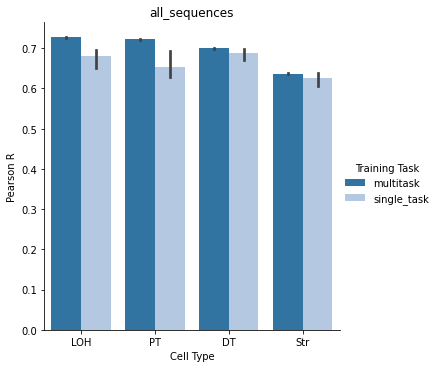

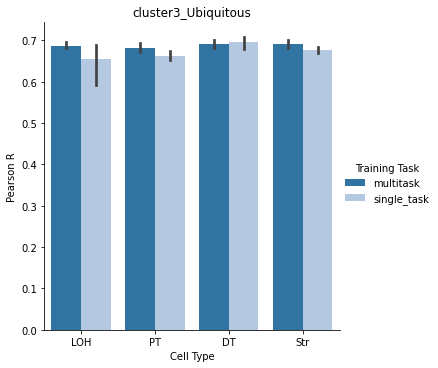

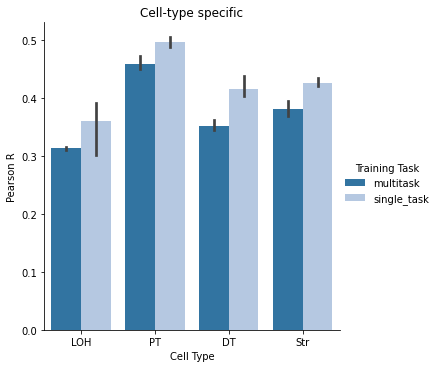

In [23]:
for cluster in ["all_sequences", "cluster3_Ubiquitous", "Cell-type specific"]:
    sns.catplot(data=formatted_df[(formatted_df["Training Data"] == "all_sequences") &
                                  (formatted_df["Cluster"] == cluster)],
                x="Cell Type", y="Pearson R", hue="Training Task", hue_order=["multitask", "single_task"],
                order=["LOH", "PT", "DT", "Str"],
                kind="bar", palette="tab20")
    plt.title(cluster)
    plt.savefig(f"{fig_dir}/fig4/loeb_et_al_{cluster}_single_multi_task_barplot.pdf", dpi=300)

### Fig 4B -- Cross cell type correlations

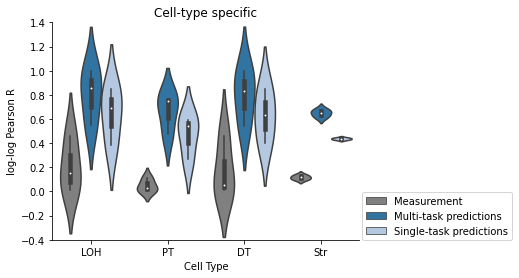

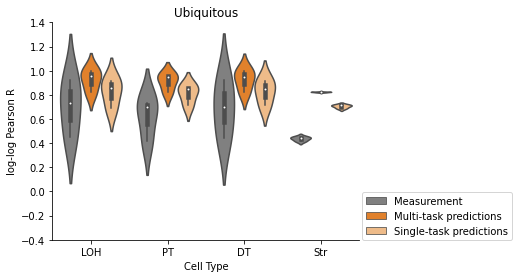

In [16]:
cmap = plt.get_cmap("tab20")

for i, cluster in enumerate(cross_cell_type_correlations["Cluster"].unique()):
    fig, ax = plt.subplots(1,1, figsize=(5.5,4))
    
    palette={"Measurement": "gray", 
             "Multi-task predictions": cmap(2*i), 
             "Single-task predictions": cmap(2*i+1)}
    
    sns.violinplot(data=cross_cell_type_correlations[cross_cell_type_correlations["Cluster"] == cluster], 
                   x="Cell Type", y="log-log Pearson R", hue="Training task", 
                   order=["LOH", "PT", "DT", "Str"],
                   hue_order=["Measurement", "Multi-task predictions", "Single-task predictions"],
                   palette=palette, scale="width")
    plt.legend(loc=(1.01,0))
    plt.title(cluster)
    plt.ylim(-0.4, 1.4)
    sns.despine()
    plt.savefig(f"{fig_dir}/fig4/loeb_et_al_{cluster}_single_multi_task_cross_cell_type_correlations.pdf",
                dpi=300)

### Supplemental figures

Reference accuracy for different training sets

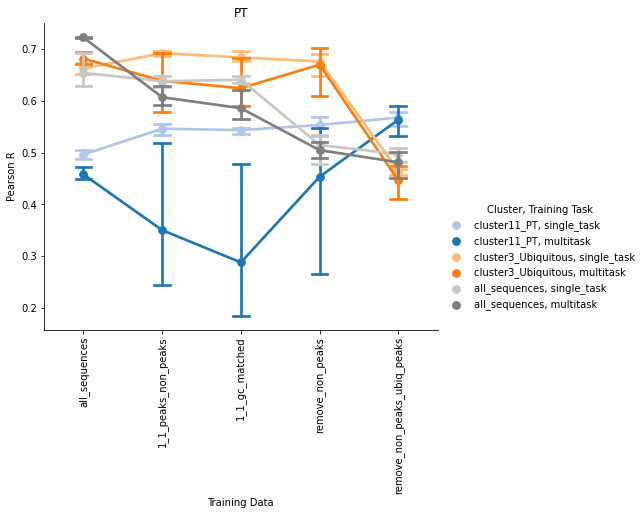

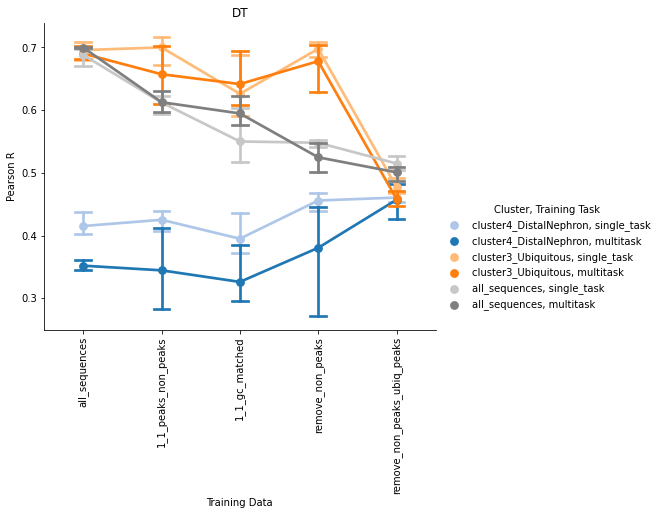

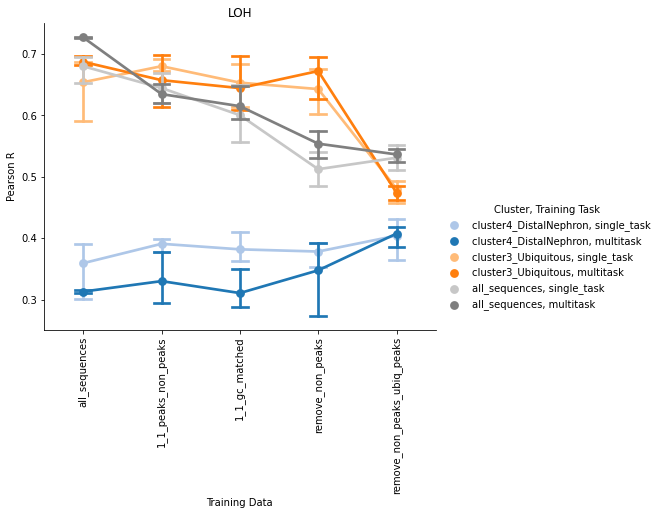

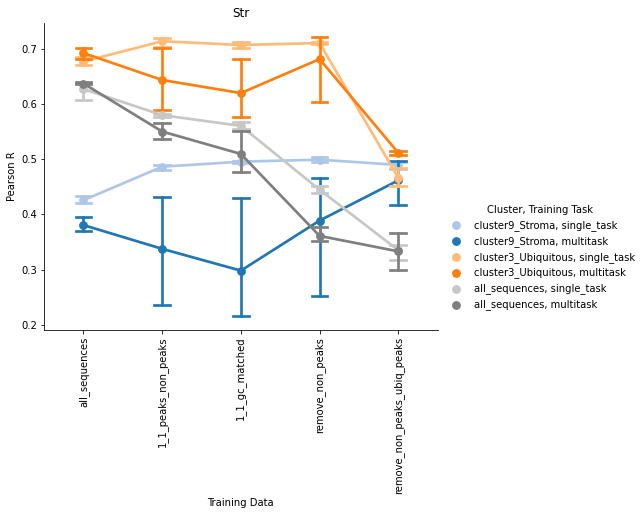

In [22]:
cmap = plt.get_cmap("tab20")
for cell_type in formatted_df["Cell Type"].unique():
    sns.catplot(data=formatted_df[(formatted_df["Cell Type"] == cell_type)], 
                x="Training Data", y="Pearson R", hue="Cluster, Training Task",
                height=5, aspect=1.3,
                capsize=0.2, errorbar="se", kind="point", 
                palette=[cmap(1), cmap(0), cmap(3), cmap(2), cmap(15), cmap(14)])
    plt.xticks(rotation=90)
    plt.title(cell_type)
    plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_{cell_type}_training_set_reference_accuracy_comparison.pdf",
                dpi=300)

Allelic imbalance accuracy

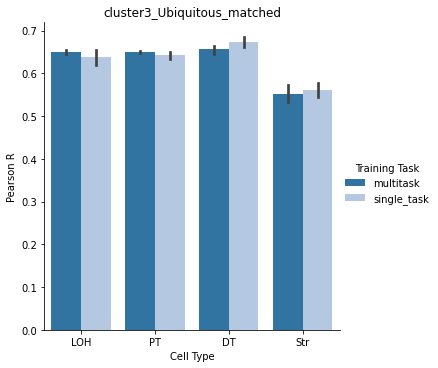

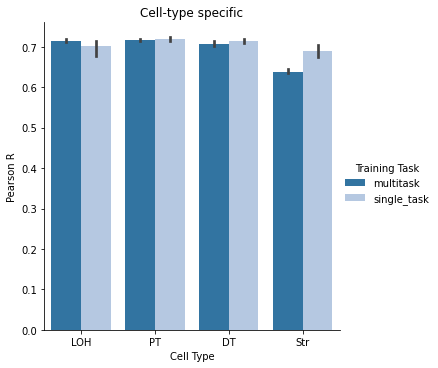

In [43]:
for cluster in [ "cluster3_Ubiquitous_matched", "Cell-type specific"]:
    sns.catplot(data=allelic_imbalance_formatted_df[(allelic_imbalance_formatted_df["Training Data"] == "all_sequences") &
                                                    (allelic_imbalance_formatted_df["Cluster"] == cluster)],
                x="Cell Type", y="Pearson R", hue="Training Task", hue_order=["multitask", "single_task"],
                order=["LOH", "PT", "DT", "Str"],
                kind="bar", palette="tab20")
    plt.title(cluster)
    plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_{cluster}_single_multi_task_allelic_imbalance_barplot.pdf",
                dpi=300)

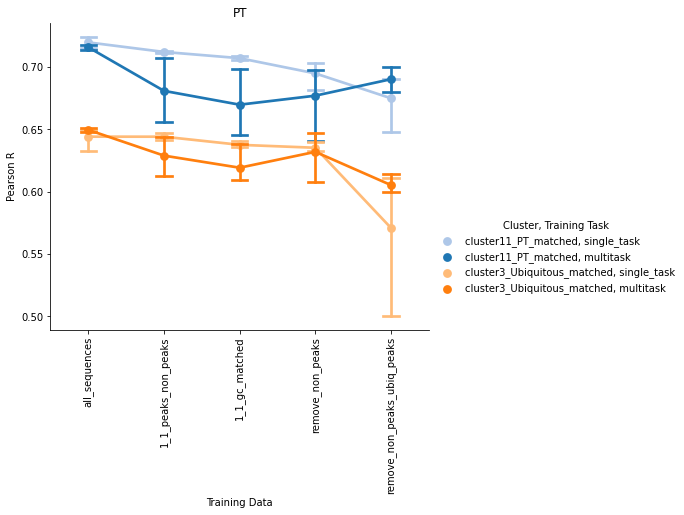

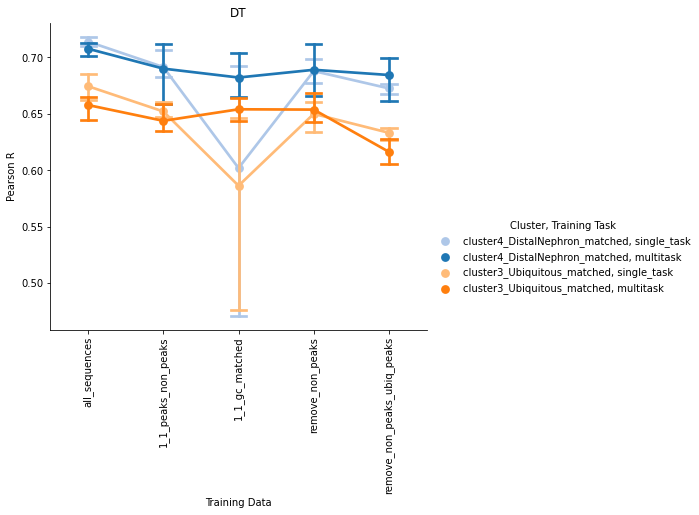

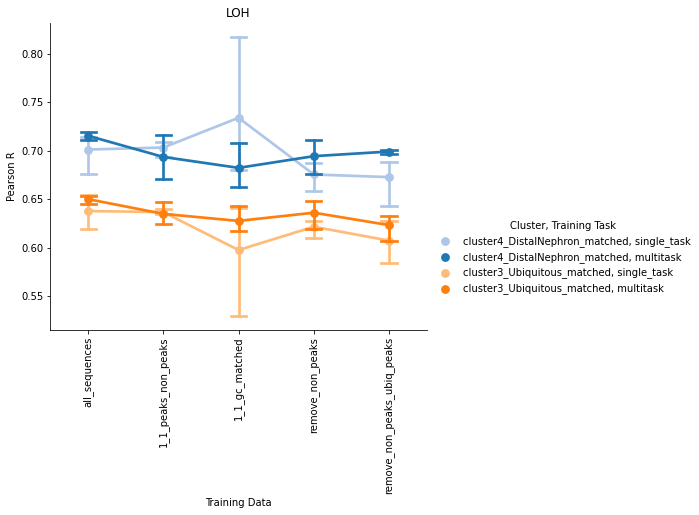

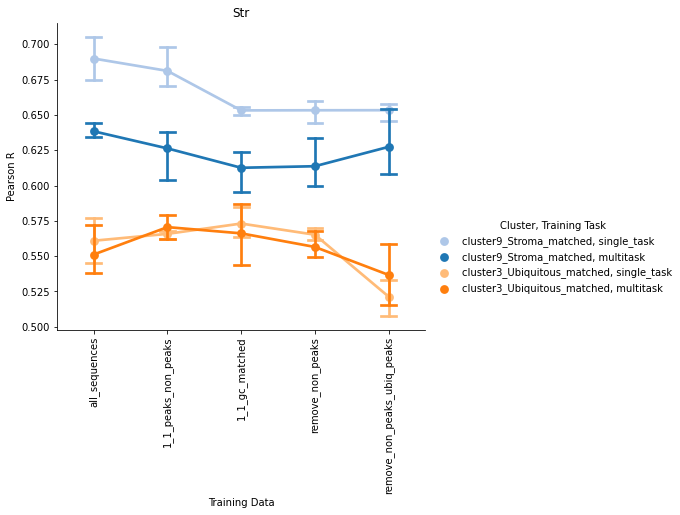

In [46]:
cmap = plt.get_cmap("tab20")
for cell_type in allelic_imbalance_formatted_df["Cell Type"].unique():
    sns.catplot(data=allelic_imbalance_formatted_df[(allelic_imbalance_formatted_df["Cell Type"] == cell_type)], 
                x="Training Data", y="Pearson R", hue="Cluster, Training Task",
                height=5, aspect=1.3,
                capsize=0.2, errorbar="se", kind="point", 
                palette=[cmap(1), cmap(0), cmap(3), cmap(2), cmap(15), cmap(14)])
    plt.xticks(rotation=90)
    plt.title(cell_type)
    plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_{cell_type}_training_set_allelic_imbalance_comparison.pdf",
                dpi=300)